# P4J Periodogram demo

A simple demonstration of a regression and periodogram computation routines using P4J

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
import time
params = {
    'axes.labelsize': 16,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'axes.titlesize': 18,
    'font.family': 'serif',
    'text.usetex': False
   }
plt.rcParams.update(params)
import P4J

## Generating a simple synthetic light curve
We create an irregulary sampled time series using a harmonic model composed of three sine waves with an specified Signal to Noise Ratio SNR)

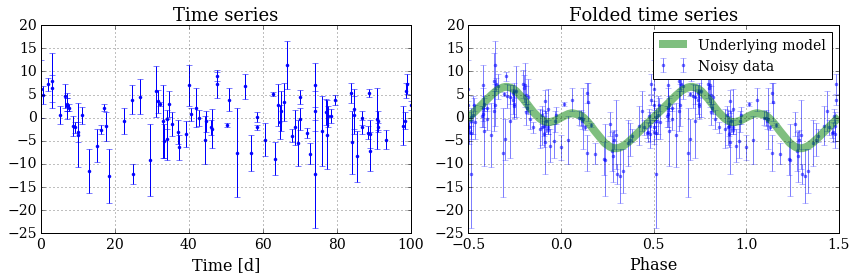

In [2]:
f0 = 2.0
t = P4J.irregular_sampling(T=100.0, N=100)
y_clean = P4J.trigonometric_model(t, f0, A=np.array([1.0, 0.5, -0.25]))
y, y_noisy, dy = P4J.contaminate_time_series(t, y_clean, SNR=0.0, red_noise_ratio=0.25, outlier_ratio=0.0)

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.errorbar(t, y_noisy, dy, fmt='.')
ax.set_xlabel('Time [d]')
ax.set_title('Time series')
plt.grid()
ax = fig.add_subplot(1, 2, 2)
phase = np.mod(t, 1/f0)*f0
index = np.argsort(phase)
ax.errorbar(np.concatenate([np.sort(phase)-0.5, np.sort(phase)+0.5]), 
            np.concatenate([y_noisy[index], y_noisy[index]]), 
            np.concatenate([dy[index], dy[index]]), fmt='.', alpha=0.5, label='Noisy data')
ax.plot(np.concatenate([np.sort(phase)-0.5, np.sort(phase)+0.5]), 
        np.concatenate([y[index], y[index]]), 
        linewidth=8, alpha=0.5, label='Underlying model')
plt.legend()
ax.set_xlabel('Phase')
ax.set_title('Folded time series')
plt.grid()
plt.tight_layout()

## Recovering the underlying model from the data

Let's try to recover the clean underlying model from the noisy data, assumming that we know the fundamental frequency (f0). In this demo we compare the Weighted Maximum Correntropy Criterion (WMCC) with the broadly used Weighted Least Squares (WLS) criterion.

Normalized Mean Squared Error (NMSE) of the fit:
WLS: 0.065549
WMCC: 0.051462


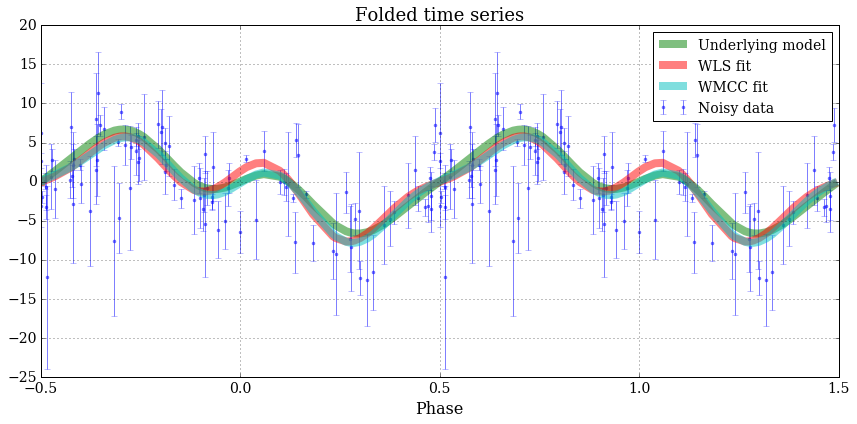

In [3]:
def NMSE(y_estimated, y_target):
    return np.sum(np.power(y_target - y_estimated, 2.0))/np.sum(np.power(y_target - np.mean(y_target), 2.0))

# We consider a harmonic dictionary with 3 components
Phi = P4J.harmonic_dictionary(t, f0, M=3)
# Data fitting
beta_WLS, cost = P4J.find_beta_WLS(y_noisy, Phi, dy)
model_WLS = np.dot(Phi, beta_WLS)
beta_WMCC, cost  = P4J.find_beta_WMCC(y_noisy, Phi, dy)
model_WMCC = np.dot(Phi, beta_WMCC)
print("Normalized Mean Squared Error (NMSE) of the fit:")
print("WLS: %f" % (NMSE(y, model_WLS)))
print("WMCC: %f" % (NMSE(y, model_WMCC)))

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
phase = np.mod(t, 1/f0)*f0
index = np.argsort(phase)
ax.errorbar(np.concatenate([np.sort(phase)-0.5, np.sort(phase)+0.5]), 
            np.concatenate([y_noisy[index], y_noisy[index]]), 
            np.concatenate([dy[index], dy[index]]), fmt='.', alpha=0.5, label='Noisy data')
ax.plot(np.concatenate([np.sort(phase)-0.5, np.sort(phase)+0.5]), 
        np.concatenate([y[index], y[index]]), 
        linewidth=8, alpha=0.5, label='Underlying model')
ax.plot(np.concatenate([np.sort(phase)-0.5, np.sort(phase)+0.5]), 
        np.concatenate([model_WLS[index], model_WLS[index]]), 
        linewidth=8, alpha=0.5, label='WLS fit')
ax.plot(np.concatenate([np.sort(phase)-0.5, np.sort(phase)+0.5]), 
        np.concatenate([model_WMCC[index], model_WMCC[index]]), 
        linewidth=8, alpha=0.5, label='WMCC fit')
plt.legend()
ax.set_xlabel('Phase')
ax.set_title('Folded time series')
plt.grid()
plt.tight_layout()

Now let's compute the average NMSE over 100 noisy realizations

In [4]:
NMSE_mat = np.zeros(shape=(500, 2))
Phi = P4J.harmonic_dictionary(t, f0, M=3)
for k in range(0, 500):
    y, y_noisy, dy = P4J.contaminate_time_series(t, y_clean, SNR=0.0, red_noise_ratio=0.25, outlier_ratio=0.0)
    beta_WLS, cost = P4J.find_beta_WLS(y_noisy, Phi, dy)
    model_WLS = np.dot(Phi, beta_WLS)
    beta_WMCC, cost = P4J.find_beta_WMCC(y_noisy, Phi, dy)
    model_WMCC = np.dot(Phi, beta_WMCC)
    NMSE_mat[k, 0] = NMSE(y, model_WLS)
    NMSE_mat[k, 1] = NMSE(y, model_WMCC)
print("NMSE of the fit")
print("WLS  mean: %f std: %f" %(np.mean(NMSE_mat, axis=0)[0], np.std(NMSE_mat, axis=0)[0]))
print("WMCC mean: %f std: %f" %(np.mean(NMSE_mat, axis=0)[1], np.std(NMSE_mat, axis=0)[1]))

NMSE of the fit
WLS  mean: 0.071537 std: 0.055130
WMCC mean: 0.043760 std: 0.025947


## Finding the best frequency using the WMCC

Now let's assumme that we do not know the best frequency for this data. To find it, we perform a fit over a set of frequencies and find the one that maximizes the WMCC. Then we can compute the false alarm probability levels for this periodgram and also the confidence associated to the maximum

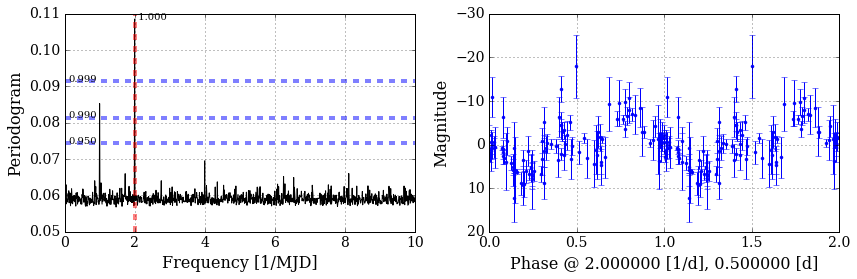

In [11]:
fig = plt.figure(figsize=(14, 4))
# We compute a periodogram using a multiharmonic dictionary (three harmonics)
my_per = P4J.periodogram(M=3, method='WMCC') # Other methods are OLS and WLS
my_per.fit(t, y_noisy, dy)
# The objective function is computed over a grid of frequencies [fmin, fmax] with step fres_coarse/T
# After that the 10 highest local maxima are fine tuned with a step of fres_fine/T
freq, per = my_per.grid_search(fmin=0.0, fmax=10.0, fres_coarse=1.0, fres_fine=0.1, n_local_max=10)
fbest = my_per.get_best_frequency()
# Fit an extreme value cdf to find the false alarm pbb of this periodogram over a bootstrap set of time series
my_per.fit_extreme_cdf(n_bootstrap=40, n_frequencies=40)
falsa_alarm = np.asarray([0.05, 0.01, 0.001])
per_levels = my_per.get_FAP(falsa_alarm)

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(freq, per, 'k-')
# Print confidence bars
xmin, xmax = ax.get_xlim()
for i in range(0, len(falsa_alarm)):
    ax.plot([xmin, xmax], [per_levels[i], per_levels[i]], 'b--', linewidth=4, alpha=0.5)
    ax.annotate('%0.3f' % (1.0-falsa_alarm[i]), xy=(xmin+0.01*(xmax-xmin), per_levels[i]))
# Print max of periodogram

ymin, ymax = ax.get_ylim()
ax.plot([fbest[0], fbest[0]], [ymin, ymax], 'r--', linewidth=4, alpha=0.5)
ax.set_ylim([ymin, ymax])
ax.set_xlabel('Frequency [1/MJD]')
ax.set_ylabel('Periodogram')
ax.annotate(' %0.3f' % (my_per.get_confidence(fbest[1])), xy=(fbest[0], fbest[1]))
plt.grid()

ax = fig.add_subplot(1, 2, 2)
phase = np.mod(t, 1.0/fbest[0])*fbest[0]
idx = np.argsort(phase)
ax.errorbar(np.concatenate([np.sort(phase), np.sort(phase)+1.0]), 
            np.concatenate([y_noisy[idx], y_noisy[idx]]),
            np.concatenate([dy[idx], dy[idx]]), fmt='.')
ax.invert_yaxis()
ax.set_xlabel('Phase @ %0.6f [1/d], %f [d]' %(fbest[0], 1.0/fbest[0]))
ax.set_ylabel('Magnitude')
plt.grid()
plt.tight_layout()